In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image, ImageDraw

In [13]:
data = pd.read_csv('10fold/pneumonia-test-0', sep=';')
data2 = pd.read_csv('10fold/pneumonia-train-0', sep=';')
data.append(data2, ignore_index=True)
print(data['Target'].value_counts())
data_empty = data.loc[data['Target'] == 0]
data = data.loc[data['Target'] != 0]
data['center_x'] = data['x'] + data['width'] / 2
data['center_y'] = data['y'] + data['height'] / 2
data.describe()

0    2101
1     900
Name: Target, dtype: int64


,x,y,width,height,Target,center_x,center_y
count,900.000000,900.000000,900.000000,900.000000,900.0,900.000000,900.000000
mean,401.865556,379.456667,213.986667,316.087778,1.0,508.858889,537.500556
std,205.179806,149.569636,57.777024,149.867380,0.0,204.951000,116.629607
min,6.000000,26.000000,59.000000,46.000000,1.0,144.500000,151.000000
25%,216.750000,258.000000,173.750000,201.000000,1.0,312.375000,459.000000
50%,343.500000,386.000000,214.000000,285.000000,1.0,425.250000,535.000000
75%,598.000000,491.000000,253.000000,409.000000,1.0,712.000000,614.750000
max,808.000000,836.000000,413.000000,808.000000,1.0,863.000000,924.500000


In [23]:
# negative samples
patients = []
for patientId in data_empty['patientId'][:20]:
    print(f"\"{patientId}\"", end=' ')
    patients.append(patientId)
print()
print(patients)

# positive samples
patients = []
for patientId in data['patientId'].drop_duplicates()[:20]:
    print(f"\"{patientId}\"", end=' ')
    patients.append(patientId)
patients

"006cec2e-6ce2-4549-bffa-eadfcd1e9970" "008c19e8-a820-403a-930a-bc74a4053664" "01b56434-4dd9-4994-bcc5-0b70a36e415a" "01cc7c75-4498-43ab-b650-5553d0507f76" "0385fdea-9b37-4039-b10c-d3094f6afdfa" "03d00867-fe6d-47b5-9a14-3f03f736e69a" "041bf0ac-a841-4c4a-9f91-45f4b3b34671" "052e09c0-6747-4f72-8e71-96fcc489043a" "05d16b06-ffb2-40ab-b64a-299448999f72" "05f42ea0-fa18-47ba-80a7-e070307300bf" "062374a3-6ca1-48d2-aa3c-820053773b54" "0638126f-126f-4f53-befe-538ff87597c6" "065b3a2f-1af3-4ebd-a740-9e49f9c685db" "068ae297-8397-463e-927e-cb6693aeb8b5" "0693cf18-a4e1-408a-a5b2-f4cabfe169d3" "06bc1cfe-23a0-43a4-a01b-dfa10314bbb0" "06e1a29a-6307-4ec2-902e-b379d39d2101" "0716e0cf-3822-406e-bfb2-c064cd471019" "0717d112-a8e5-46c0-9ba5-902cd9fe8fe1" "07444c7a-580b-4494-a883-3b33361a24ac" 
['006cec2e-6ce2-4549-bffa-eadfcd1e9970', '008c19e8-a820-403a-930a-bc74a4053664', '01b56434-4dd9-4994-bcc5-0b70a36e415a', '01cc7c75-4498-43ab-b650-5553d0507f76', '0385fdea-9b37-4039-b10c-d3094f6afdfa', '03d00867-fe6d-47b

['0174c4bb-28f5-41e3-a13f-a396badc18bd',
 '01fa0f5e-00c3-41cb-b5c7-10600c8633ae',
 '040a0743-f663-4746-8224-f0e3bacc7ba5',
 '0499513a-5d48-4cf9-aac8-115e2a52fe1a',
 '0587782c-ac6b-4ae1-8ffb-ce894d09f75e',
 '05bb6f8d-453b-4e56-ae92-2600e058ba65',
 '05fe7d73-5c8c-4349-88c4-2071a00d6d81',
 '0637b804-e693-48d1-8716-f7c63ce6162a',
 '06d5a58d-baf1-4937-bfc3-00db1fb2b1be',
 '06e09ebb-cb5b-4c30-8d3a-67a6ec34692b',
 '06f5a38a-e4b1-4e5f-8c62-f48630a52504',
 '077780cb-eb05-478f-a7d7-f0576e4c34df',
 '0808c4af-9ed6-46e3-a936-2cafb0004e6a',
 '08307845-ccbd-4616-b8e9-58532a766dbe',
 '08f17660-dc61-4a5d-b6fb-10dacc1e20a2',
 '091cc2b7-8ba6-4fce-8ae2-7547117dbddf',
 '091d75a8-e23e-4cb8-af67-10cb314077ec',
 '0927e819-9640-487d-a04e-f5d4732dbe0a',
 '0a8d486f-1aa6-4fcf-b7be-4bf04fc8628b',
 '0a8efdc1-1dff-4d65-8948-c56a5d74a906']

In [15]:
repeated = data.copy()
repeated = repeated.loc[repeated.duplicated(subset='patientId', keep=False)].reset_index(drop=True)
patients = []
num_repetitions = []
x_center = []
x_min = []
x_max = []
y_center = []
y_min = []
y_max = []
for k in range(len(repeated)):
    entry = repeated.iloc[k].to_dict()
    if k == 0 or patients[-1] != entry['patientId']:
        x_min.append(entry['x'])
        y_min.append(entry['y'])
        x_max.append(entry['x'] + entry['width'])
        y_max.append(entry['y'] + entry['height'])
        num_repetitions.append(1)
        x_center.append(entry['center_x'])
        y_center.append(entry['center_y'])
        patients.append(entry['patientId'])
    else:
        num_repetitions[-1] += 1
        if x_min[-1] > entry['x']:
            x_min[-1] = entry['x']
        if y_min[-1] > entry['y']:
            y_min[-1] = entry['y']
        if x_max[-1] < entry['x'] + entry['width']:
            x_max[-1] = entry['x'] + entry['width']
        if y_max[-1] < entry['y'] + entry['height']:
            y_max[-1] = entry['y'] + entry['height']

repeated = pd.DataFrame.from_dict({'patientId': patients,
                         'x_min': x_min,
                         'x_max': x_max,
                         'y_min': y_min,
                         'y_max': y_max,
                         })
repeated['center_x'] = (repeated['x_max'] + repeated['x_min']) / 2
repeated['center_y'] = (repeated['y_max'] + repeated['y_min']) / 2
repeated['width'] = repeated['x_max'] - repeated['x_min']
repeated['height'] = repeated['y_max'] - repeated['y_min']
repeated.describe()

,x_min,x_max,y_min,y_max,center_x,center_y,width,height
count,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000
mean,217.305994,825.170347,322.861199,742.091483,521.238170,532.476341,607.864353,419.230284
std,76.802132,68.488999,139.339399,112.348299,56.974727,102.039171,90.521505,149.757295
min,6.000000,463.000000,70.000000,417.000000,312.000000,258.500000,217.000000,121.000000
25%,162.000000,788.000000,214.000000,671.000000,488.000000,459.500000,553.000000,305.000000
50%,220.000000,826.000000,319.000000,735.000000,523.000000,527.500000,606.000000,402.000000
75%,266.000000,868.000000,418.000000,815.000000,556.500000,601.500000,661.000000,522.000000
max,422.000000,988.000000,760.000000,1014.000000,662.000000,831.000000,894.000000,811.000000


In [16]:
unique = data.loc[~data.duplicated(subset='patientId', keep=False)].reset_index(drop=True)
unique['min_x'] = unique['x']
unique['min_y'] = unique['y']
unique['center_x'] = unique['min_x'] + unique['width'] / 2
unique['center_y'] = unique['min_y'] + unique['height'] / 2
unique.describe()

,x,y,width,height,Target,center_x,center_y,min_x,min_y
count,250.000000,250.000000,250.000000,250.000000,250.0,250.00000,250.000000,250.000000,250.000000
mean,384.072000,422.148000,207.600000,254.948000,1.0,487.87200,549.622000,384.072000,422.148000
std,207.826201,138.943222,62.610737,129.575896,0.0,204.95885,117.287902,207.826201,138.943222
min,42.000000,26.000000,65.000000,60.000000,1.0,178.00000,151.000000,42.000000,26.000000
25%,205.000000,340.250000,162.500000,166.500000,1.0,307.75000,483.750000,205.000000,340.250000
50%,295.500000,437.500000,206.000000,232.000000,1.0,375.00000,562.500000,295.500000,437.500000
75%,596.000000,507.750000,248.000000,304.000000,1.0,702.87500,615.125000,596.000000,507.750000
max,808.000000,807.000000,413.000000,808.000000,1.0,859.00000,912.000000,808.000000,807.000000


In [17]:
from sklearn.mixture import GaussianMixture
def double_gaussian(dataframe_column):
    return GaussianMixture(n_components=2).fit(dataframe_column.to_numpy().reshape(-1, 1))

def display_double_gaussian(distribution):
    means_hat = distribution.means_.flatten()
    weights_hat = distribution.weights_.flatten()
    sds_hat = np.sqrt(distribution.covariances_).flatten()
    
    print(distribution.converged_)
    print(means_hat)
    print(sds_hat)
    print(weights_hat)
    
    base = np.linspace(0, 1024, 100)
    return plt.plot(base, np.exp(distribution.score_samples(base[:, np.newaxis])))


True
[219.07902604 606.1511988 ]
[74.54711271 61.36654274]
[0.52777145 0.47222855]


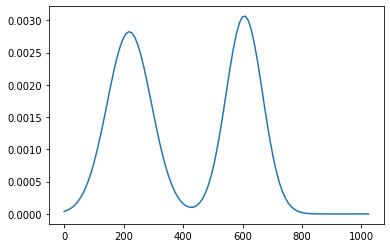

In [18]:
mixture = double_gaussian(data['x'])
display_double_gaussian(mixture)

True
[323.24896318 716.005851  ]
[61.88502827 56.14732806]
[0.52741777 0.47258223]


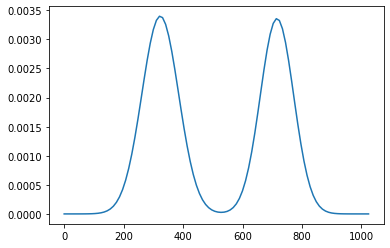

In [19]:
center_x_dist = double_gaussian(data['center_x'])
display_double_gaussian(mixture)

In [7]:
def draw_rectangle(image, x_min, y_min, width, height, color='yellow', size=1):
    draw = ImageDraw.Draw(image)
    coordinates = [x_min, y_min, x_min + width + 1, y_min + height + 1]
    draw.rectangle(xy=coordinates, width=size, outline=color)
    return image

def show_grid(images, images_per_line=3):
    #creates a new empty image, RGB mode, and size 400 by 400.
    width, height = images[0].size
    num_lines = int(np.ceil(len(images) / images_per_line))
    grid_width = int(width * images_per_line)
    grid_height = int(height * num_lines)
    background = Image.new('RGB', (grid_width, grid_height))
    
    #Iterate through a 4 by 4 grid with 100 spacing, to place my image
    for i in range(num_lines):
        for j in range(images_per_line):
            idx = i * images_per_line + j
            image = images[idx]
            x = j * width
            y = i * height
            #paste the image at location i,j:
            background.paste(image, (x,y))
    
    return background

In [8]:
num_images = 10
names = []
for i in range(num_images):
    data_filtered = data.drop_duplicates(subset='patientId')
    example = data_filtered.iloc[i]
    patientId = example['patientId']
    name = patientId + '.jpg'
    print(name)
    names.append(name)

images = []
for i in range(num_images):
    name = names[i]
    examples = data.loc[data['patientId'] == name[:-4]]
    
    image = Image.open(os.path.join('images/train', name))
    
    for j in range(len(examples)):
        example = examples.iloc[j]
        image = draw_rectangle(image=image,
                                 x_min=example['x'],
                                 y_min=example['y'],
                                 width=example['width'],
                                 height=example['height'],
                                 color='yellow',
                                 size=4)
    images.append(image)
# show_grid(images, images_per_line=2)

0174c4bb-28f5-41e3-a13f-a396badc18bd.jpg
01fa0f5e-00c3-41cb-b5c7-10600c8633ae.jpg
040a0743-f663-4746-8224-f0e3bacc7ba5.jpg
0499513a-5d48-4cf9-aac8-115e2a52fe1a.jpg
0587782c-ac6b-4ae1-8ffb-ce894d09f75e.jpg
05bb6f8d-453b-4e56-ae92-2600e058ba65.jpg
05fe7d73-5c8c-4349-88c4-2071a00d6d81.jpg
0637b804-e693-48d1-8716-f7c63ce6162a.jpg
06d5a58d-baf1-4937-bfc3-00db1fb2b1be.jpg
06e09ebb-cb5b-4c30-8d3a-67a6ec34692b.jpg
